In [1]:
import sys
sys.path.append('../')

import torch
import random
from tqdm import tqdm
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from MCTensor import MCTensor
from MCTensor.MCModule import MCLinear
from MCTensor import MCOptim

d16 = torch.float16; d32 = torch.float32; d64 = torch.float64
cpu = torch.device("cpu"); gpu = torch.device(type='cuda', index=0)
# set device
device = gpu

In [2]:
def generate_linear_data(data_size, mean_std_data, mean_std_weight, dim=256, seed=1234,
                         save_path=None):
    np.random.seed(seed)
    mean_data, std_data = mean_std_data
    X = np.random.normal(loc=mean_data, scale=std_data, size=(data_size, dim)) 
    mean_weight, std_weight = mean_std_weight
    weights = np.random.normal(loc=mean_weight, scale=std_weight, size=(dim)) 
    y = X @ weights
    if save_path is not None:
      np.save(save_path+"linear_X.npy", X)
      np.save(save_path+"linear_y.npy", y)
      np.save(save_path+"linear_weights.npy", weights)
    return X, y, weights

dimension = 5; data_size = 10
X, y, _ = generate_linear_data(data_size, [-1, 1.5], [-1, 1.5], dim=dimension, save_path="data/")
#X, y, _ = generate_linear_data(data_size, [-3.3, 3.5], [-3.5, 1.5], dim=dimension, save_path="data/")
X16, y16 = torch.from_numpy(X).to(d16).to(device), torch.from_numpy(y).to(d16).to(device).unsqueeze(-1)
X32, y32 = torch.from_numpy(X).to(d32).to(device), torch.from_numpy(y).to(d32).to(device).unsqueeze(-1)
X64, y64 = torch.from_numpy(X).to(d64).to(device), torch.from_numpy(y).to(d64).to(device).unsqueeze(-1)
init_weight = torch.randn(dimension, 1, dtype=d64)

def get_input_dtype(dtype):
  if dtype == d16:
    dtype = d16; input = X16; target = y16 
  elif dtype == d32:
    dtype = d32; input = X32; target = y32  
  elif dtype == d64:
    dtype = d64; input = X64; target = y64  
  return dtype, input, target 

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
# float16 doesn't support mse backward on CPU, hardcoding
def MSE(output, target):
  loss = (torch.norm(output-target))**2/target.size().numel()
  return loss


class LinearRegression(nn.Module):
    def __init__(self, input_dim, dtype, device, init_weight=None):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False,
                                dtype=dtype, device=device)
        if init_weight is not None:
            self.linear.weight.data = init_weight.clone().to(device)
            self.linear.weight.requires_grad_()

    def forward(self, x):
        out = self.linear(x)
        return out
    
    


class MCLinearRegression(nn.Module):
    def __init__(self, input_dim, nc, dtype, device, init_weight=None):
        super(MCLinearRegression, self).__init__()
        self.linear = MCLinear(input_dim, 1, nc, bias=False,
                               dtype=dtype, device=device, _weight=init_weight)
        
    def forward(self, x):
        out = self.linear(x)
        return out
    
    def parameters(self):
        return self.linear.parameters()

In [5]:
def train_MC_linear(dtype, nc=2, lr=0.015, epochs=500, device=cpu):
  seed_everything()
  dtype, input, target = get_input_dtype(dtype)
  model = MCLinearRegression(dimension, nc, dtype=dtype, device=device, 
                            init_weight=init_weight.t().to(dtype))
  mc_optimizer = MCOptim.MCSGD(model.parameters(), lr)
#   mc_optimizer = MCOptim.MCAdam(model.parameters(), lr)
  criterion = MSE
  LOSS= np.zeros(epochs)
  for i in tqdm(range(epochs)):
    mc_optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, target)
    loss_64 = criterion(output.to_type(d64), target.to(d64)).item()
    #print("iter:", i, loss.item(), loss_64)
    LOSS[i] = loss_64
    loss.backward()  
    mc_optimizer.step()
  return LOSS

In [6]:
def train_linear(dtype, lr=0.015, epochs=500, device=cpu):
  seed_everything()
  dtype, input, target = get_input_dtype(dtype)
  model = LinearRegression(dimension, dtype=dtype, device=device,
                          init_weight=init_weight.t().to(dtype))
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#   optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = MSE 
  LOSS= np.zeros(epochs)
  for i in tqdm(range(epochs)):
      optimizer.zero_grad()                                                     
      output = model(input)
      loss = criterion(output, target)
      loss_64 = criterion(output.to(d64), target.to(d64)).item()
      #print("iter:", i, loss.item(), loss_64)
      LOSS[i] = loss_64
      loss.backward()
      optimizer.step()
  return LOSS

#### Plotting graphs for 1) torch with float16, float32, float64; 2) MCT16 with nc = 1,2,3

In [7]:
lr = 0.04; epochs = 2000
MCT_loss_nc1 = train_MC_linear(d16, nc=1, lr=lr, epochs=epochs,  device=device)
MCT_loss_nc2 = train_MC_linear(d16, nc=2, lr=lr, epochs=epochs,  device=device)
MCT_loss_nc3 = train_MC_linear(d16, nc=3, lr=lr, epochs=epochs,  device=device)
print("final losses for MCT:", MCT_loss_nc1[-1], MCT_loss_nc2[-1], MCT_loss_nc3[-1])

100%|██████████| 2000/2000 [00:35<00:00, 57.08it/s]

final losses for MCT: 0.0006166458129882812 1.972186601051362e-06 1.9735998602499196e-06


In [8]:
lr = 0.04; epochs = 2000
torch_loss_16 = train_linear(d16, lr=lr, epochs=epochs, device=device)
torch_loss_32 = train_linear(d32, lr=lr, epochs=epochs, device=device)
torch_loss_64 = train_linear(d64, lr=lr, epochs=epochs, device=device)
print("final losses for torch:", torch_loss_16[-1], 
      torch_loss_32[-1], torch_loss_64[-1])

100%|██████████| 2000/2000 [00:03<00:00, 531.70it/s]

final losses for torch: 0.0005063056945800781 8.253664418589325e-12 2.5110428689316333e-29


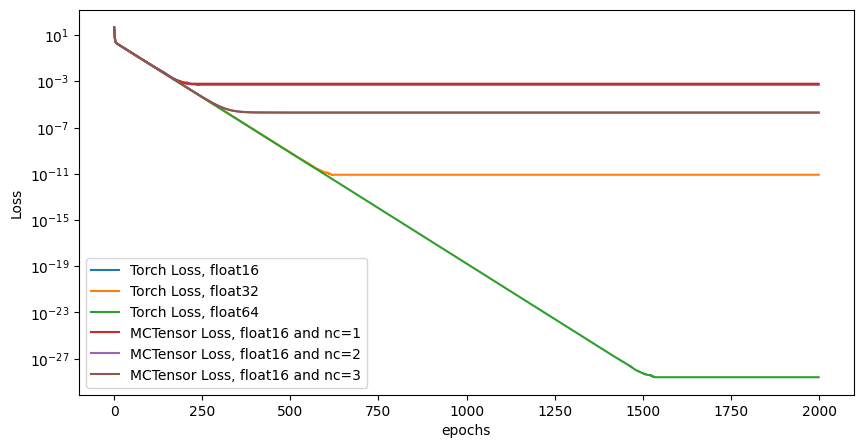

In [9]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), torch_loss_16, label="Torch Loss, float16")
plt.plot(range(epochs), torch_loss_32, label="Torch Loss, float32")
plt.plot(range(epochs), torch_loss_64, label="Torch Loss, float64")

plt.plot(range(epochs), MCT_loss_nc1, label="MCTensor Loss, float16 and nc=1")
plt.plot(range(epochs), MCT_loss_nc2, label="MCTensor Loss, float16 and nc=2")
plt.plot(range(epochs), MCT_loss_nc3, label="MCTensor Loss, float16 and nc=3")
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.yscale('log')

plt.legend()
plt.show()